In [1]:
#!pip install xgboost

In [2]:
import pandas as pd;import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score,roc_curve,accuracy_score, recall_score, confusion_matrix,classification_report, precision_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from IPython.display import HTML 
from sklearn.metrics import precision_recall_fscore_support as score

In [3]:
pd.set_option('display.max_columns', None)

### Load the data and high level validattion

In [4]:
HotelDf = pd.read_csv('Hotel_EDA_Final.csv') # Load the csv file post pre pressing and EDA
HotelDf.head(5) # List the first 5 values fromt he data

,hotel,is_canceled,booking_date,arrival_date,stays_in_weekend_nights,stays_in_week_nights,adults,children,meal,country,market_segment,distribution_channel,is_repeated_customer,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,required_car_parking_spaces,totalno_of_special_requests,total_guest,a_year,a_month,a_day,a_day_of_week,a_weekno,leadtime,c_name,location,country_type,total_stays,booking_changes_new,leadtime_month,previous_cancellations_new,previous_bookings_not_canceled_new,book_via_company,book_by_agent
0,type_2,0,2017-07-24,2018-07-01,0,0,2,0,Only Breakfast,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,No Agent,No Company,0,Transient,0,0,2,2018,July,1,Sunday,26,342.0,Portugal,Portugal,Local,0.0,1,11,No,No,Booking Not Via Company,Not Agent Booking
1,type_2,0,2016-06-24,2018-07-01,0,0,2,0,Only Breakfast,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,No Agent,No Company,0,Transient,0,0,2,2018,July,1,Sunday,26,373.0,Portugal,Portugal,Local,0.0,1,24,No,No,Booking Not Via Company,Not Agent Booking
2,type_2,0,2018-06-24,2018-07-01,0,1,1,0,Only Breakfast,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,No Agent,No Company,0,Transient,0,0,1,2018,July,1,Sunday,26,7.0,United Kingdom,Western Europe,International,1.0,0,0,No,No,Booking Not Via Company,Not Agent Booking
3,type_2,0,2018-06-18,2018-07-01,0,1,1,0,Only Breakfast,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,No Company,0,Transient,0,0,1,2018,July,1,Sunday,26,13.0,United Kingdom,Western Europe,International,1.0,0,0,No,No,Booking Not Via Company,Agent Booking
4,type_2,0,2018-06-17,2018-07-01,0,2,2,0,Only Breakfast,GBR,Online Travel Agents,TA/TO,0,0,0,A,A,0,No Deposit,240.0,No Company,0,Transient,0,1,2,2018,July,1,Sunday,26,14.0,United Kingdom,Western Europe,International,2.0,0,0,No,No,Booking Not Via Company,Agent Booking


In [5]:
HotelDf['agent'] = HotelDf['agent'].apply(lambda x: 0 if x=='No Agent' else x)

In [6]:
# Preprocessing labels using .map because there are only 2 unique values
HotelDf['hotel_encoded'] = HotelDf['hotel'].map({'type_1': 1, 'type_2':0})
HotelDf['previous_cancellations_encoded'] = HotelDf['previous_cancellations_new'].map({'Yes': 1, 'No':0})
HotelDf['previous_cancellations_not_encoded'] = HotelDf['previous_bookings_not_canceled_new'].map({'Yes': 1, 'No':0})
HotelDf['book_via_company_encoded'] =HotelDf['book_via_company'].map({'Booking Via Company':1, 'Booking Not Via Company':0})
HotelDf['book_by_agent_encoded'] =HotelDf['book_by_agent'].map({'Agent Booking':1, 'Not Agent Booking':0})

deposit_type_encoded = pd.get_dummies(HotelDf['deposit_type'],prefix="deposit_type",drop_first=True)
market_segment_encoded = pd.get_dummies(HotelDf['market_segment'],prefix="market_segment",drop_first=True)
distribution_channel_encoded = pd.get_dummies(HotelDf['distribution_channel'],prefix="distribution_channel",drop_first=True)
customer_type_encoded = pd.get_dummies(HotelDf['customer_type'],prefix="customer_type",drop_first=True)
assigned_room_type_encoded = pd.get_dummies(HotelDf['assigned_room_type'],prefix="assigned_room_type",drop_first=True)
location_encoded = pd.get_dummies(HotelDf['location'],prefix="location",drop_first=True)
meal_encoded = pd.get_dummies(HotelDf['meal'],prefix="meal",drop_first=True)

HotelDf = pd.concat([HotelDf,deposit_type_encoded,market_segment_encoded,distribution_channel_encoded,customer_type_encoded,assigned_room_type_encoded,location_encoded,meal_encoded],axis=1)

HotelDf['booking_date'] = HotelDf['booking_date'].str.replace('-','')
HotelDf['arrival_date'] = HotelDf['arrival_date'].str.replace('-','')

#Drop Encoded variables
HotelDf.drop(['deposit_type','market_segment','distribution_channel','customer_type','assigned_room_type','location','hotel','previous_cancellations_new','previous_bookings_not_canceled_new','book_via_company','book_by_agent'],axis=1,inplace=True)

#Drop Other variables
ModelDf = HotelDf.drop(['company','arrival_date','booking_changes','book_by_agent_encoded','country_type','c_name','country','leadtime_month','previous_cancellations','is_repeated_customer','previous_bookings_not_canceled','children','stays_in_weekend_nights','total_stays','stays_in_week_nights','meal','total_guest','days_in_waiting_list','adults','a_day_of_week','a_month','a_day','a_weekno','a_year','reserved_room_type'],axis=1).copy()

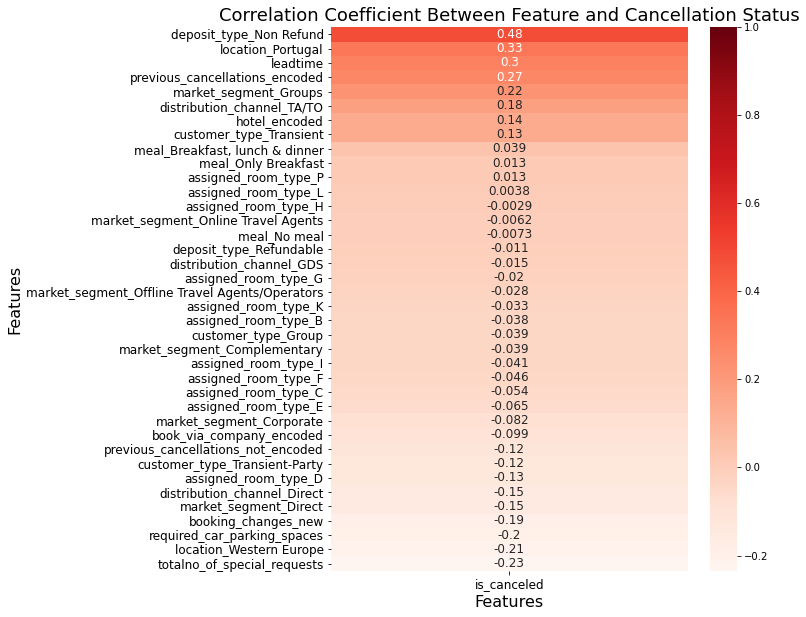

In [7]:
# Visualizing correlation coefficients between features and cancellation:
fig = plt.figure(figsize=(8,10))
ax = sns.heatmap(ModelDf.corr()[['is_canceled']].sort_values('is_canceled', ascending=False), annot = True, annot_kws = {"size":12}, cmap='Reds')
ax.set_title('Correlation Coefficient Between Feature and Cancellation Status', fontsize=18)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12);
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1);

In [8]:
cordf = ModelDf.corr()[['is_canceled']].sort_values('is_canceled', ascending=False)
cordf[(cordf['is_canceled']>=0.2) | (cordf['is_canceled']<=-0.2)]

,is_canceled
is_canceled,1.000000
deposit_type_Non Refund,0.481457
location_Portugal,0.331595
leadtime,0.295173
previous_cancellations_encoded,0.270943
market_segment_Groups,0.221859
location_Western Europe,-0.212401
totalno_of_special_requests,-0.234658


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(ModelDf.drop(['is_canceled','agent','booking_date'],axis=1).values, ix) for ix in range(ModelDf.drop(['is_canceled','agent','booking_date'],axis=1).shape[1])] 
i=0
vs = [[None for j in range(3)] for i in range(ModelDf.drop(['is_canceled','agent','booking_date'],axis=1).columns.shape[0])]

for column in ModelDf.drop(['is_canceled','agent','booking_date'],axis=1).columns:
        if vif[i] <= 1:
            corrange='Not'
        elif vif[i] >1 and vif[i] <10:
            corrange ='Moderately'
        else:
            corrange ='Highly'
        #print(f"Column {column} --> VIF : {round(vif[i],2)} and {corrange} correlated")
        vs[i][0] = column
        vs[i][1] = round(vif[i],2)
        vs[i][2] = corrange
        i=i+1
vdf = pd.DataFrame(data=vs,columns=['Feature','Corr','CorrFactor'])

In [10]:
vdf[vdf['CorrFactor']=='Highly']

,Feature,Corr,CorrFactor
12,market_segment_Direct,16.36,Highly
13,market_segment_Groups,18.62,Highly
14,market_segment_Offline Travel Agents/Operators,22.47,Highly
15,market_segment_Online Travel Agents,54.63,Highly
16,distribution_channel_Direct,12.41,Highly
18,distribution_channel_TA/TO,56.46,Highly
20,customer_type_Transient,23.65,Highly


<AxesSubplot:>

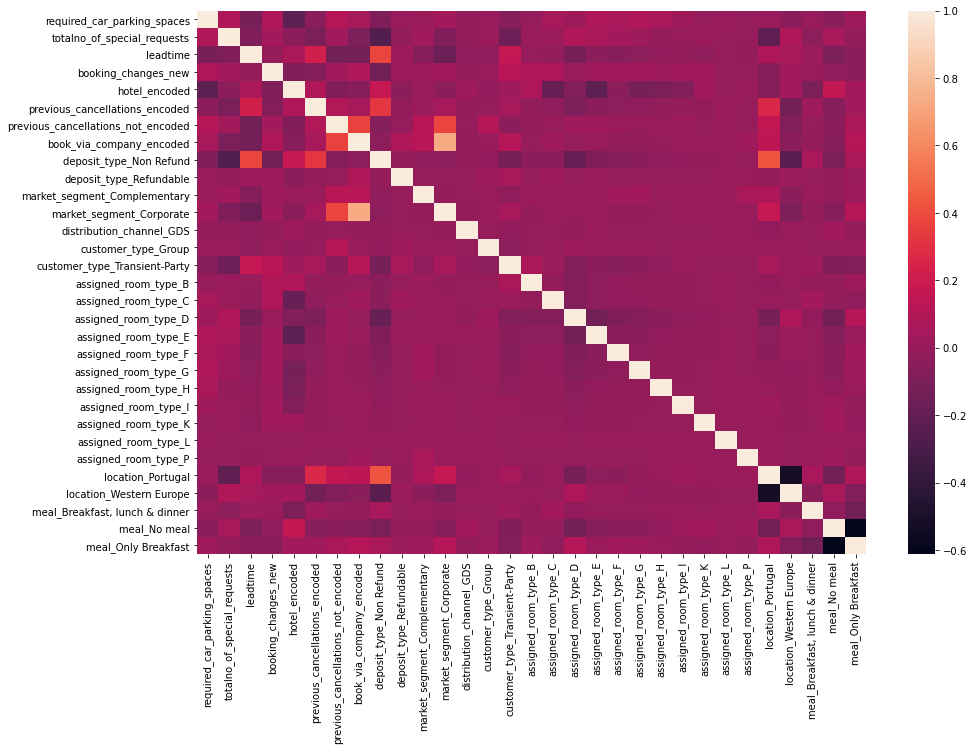

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(ModelDf[vdf[vdf['CorrFactor']!='Highly']['Feature']].corr())

In [12]:
def display_dataframe(df):
    numeric_col_mask = df.dtypes.apply(lambda d: issubclass(np.dtype(d).type, np.number))

    # Dict used to center the table headers
    d = dict(selector="th",
        props=[('text-align', 'center')])

    # Style
    display(df.style.set_properties(subset=df.columns[numeric_col_mask], # right-align the numeric columns and set their width
                            **{'width':'5em', 'height':'3em','text-align':'right','border-color': 'white','border-style' :'solid'})\
            .set_properties(subset=df.columns[~numeric_col_mask], # left-align the non-numeric columns and set their width
                            **{'width':'5em', 'text-align':'left'})\
            .format(lambda x: '{:,.0f}'.format(x) if x > 1e3 else '{:,.2f}'.format(x), # format the numeric values
                    subset=pd.IndexSlice[:,df.columns[numeric_col_mask]])\
            .hide_index()\
#            .highlight_max('color: green')\
            .set_table_styles([d])) # center the header

In [13]:
#AUC and ROC Value
def roc_model(model_name,x,y):
    # predict probabilities
    probs = model_name.predict_proba(x)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y, probs)
    fpr, tpr, _ = roc_curve(y, probs)
    return probs,auc,fpr,tpr

In [14]:
def con_mat(y_train,y_predict_train,y_test,y_predict_test):
    fig, axis=plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(10,4)
    fig.tight_layout()

    cm=confusion_matrix(y_train,y_predict_train,labels=[0, 1])

    df_cm = pd.DataFrame(cm, index = [i for i in ["Not Canceled","Canceled"]],
    columns = [i for i in ["Not Canceled","Canceled"]])
    sns.heatmap(df_cm, annot=True ,fmt='g',ax=axis[0])
    axis[0].title.set_text('Confustion Matrix - Train Data')

    cm=confusion_matrix(y_test,y_predict_test,labels=[0, 1])

    df_cm = pd.DataFrame(cm, index = [i for i in ["Not Canceled","Canceled"]],
    columns = [i for i in ["Not Canceled","Canceled"]])
    sns.heatmap(df_cm, annot=True ,fmt='g',ax=axis[1])
    axis[1].title.set_text('Confustion Matrix - Test Data')

In [15]:
def scores_train_test(model,X_train,X_test,y_train,y_test,y_predict_train,y_predict_test,mname,model_name):
    #model=bgcl
    from IPython.display import HTML 
    from sklearn.metrics import precision_recall_fscore_support as score

    s = [[None for j in range(6)] for i in range(2)]

    print(model_name)
    print('********************************\n')

    #model_name = str(model).split('(')[0]
    s[0][0] = model_name + '_' + mname +'_Train'
    s[1][0] = model_name + '_' + mname +'_Test'
    
    report_train = classification_report(y_train, y_predict_train, output_dict=True)
    report_test = classification_report(y_test, y_predict_test, output_dict=True)

    s[0][1]=round(report_train['1']['precision']*100,2)
    s[1][1]=round(report_test['1']['precision']*100,2)

    s[0][2]=round(report_train['1']['recall']*100,2)
    s[1][2]=round(report_test['1']['recall']*100,2)

    s[0][3]=round(report_train['1']['f1-score']*100,2)
    s[1][3]=round(report_test['1']['f1-score']*100,2)

    s[0][4]=round(report_train['accuracy']*100,2)
    s[1][4]=round(report_test['accuracy']*100,2)

    probs, auc, fpr, tpr = roc_model(model,X_train,y_train)
    probst, auc1, fpr1, tpr1 = roc_model(model,X_test,y_test)

    s[0][5]=round(auc*100,2)
    s[1][5]=round(auc1*100,2)

    df = pd.DataFrame(data=s,columns=['Scores','Precision','Recall','F-Score','Accuracy','AUC'])

    con_mat(y_train,y_predict_train,y_test,y_predict_test)

    plt.figure(figsize=(5,5))

    plt.plot(fpr,tpr, marker='o', label='AUC - Train:' + str(s[0][5]))
    plt.plot(fpr1,tpr1, marker='o', label='AUC - Test:' + str(s[1][5]))

    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')

    display_dataframe(df)
    return(df)

In [16]:
def con_mat_r(y_train,y_predict_train,y_test,y_predict_test,nc,he,wi,tit):
    nc = len(y_predict_train)

    fig, axis=plt.subplots(nrows=nc,ncols=2)
    fig.set_size_inches(he,wi)
    fig.tight_layout()

    
    c=0
    for i in y_predict_train:
        cm=confusion_matrix(y_train,i,labels=[0, 1])

        df_cm = pd.DataFrame(cm, index = [i for i in ["Not Canceled","Canceled"]],
        columns = [i for i in ["Not Canceled","Canceled"]])

        sns.heatmap(df_cm, annot=True ,fmt='g',ax=axis[c][0])
        axis[c][0].title.set_text(tit[c] + ' - Train Data')
        c=c+1

    c=0
    for i in y_predict_test:
        cm=confusion_matrix(y_test,i,labels=[0, 1])

        df_cm = pd.DataFrame(cm, index = [i for i in ["Not Canceled","Canceled"]],
        columns = [i for i in ["Not Canceled","Canceled"]])

        sns.heatmap(df_cm, annot=True ,fmt='g',ax=axis[c][1])
        axis[c][1].title.set_text(tit[c] + ' - Test Data')
        c=c+1


### Split the data for training and testing

In [17]:
X = ModelDf.drop('is_canceled',axis=1)
y = ModelDf['is_canceled']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.15,random_state=9)

In [19]:
X_train.shape

(101481, 40)

In [20]:
X_test.shape

(17909, 40)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [22]:
sc_train = scaler.fit_transform(X_train)
X_train_sc = pd.DataFrame(sc_train, index=X_train.index, columns=X_train.columns)

In [23]:
sc_test = psc_test = scaler.transform(X_test)
X_test_sc = pd.DataFrame(sc_test, index=X_test.index, columns=X_test.columns)

In [24]:
# invoke the LinearRegression function
lgr_model = LogisticRegression(random_state=0)
lgr_model.fit(X_train_sc,y_train)

lgr_train=lgr_model.predict(X_train_sc)
lgr_test=lgr_model.predict(X_test_sc)

LogisticRegression
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
LogisticRegression_Base_Train,80.45,61.73,69.86,80.27,88.38
LogisticRegression_Base_Test,80.96,62.00,70.22,80.52,88.60


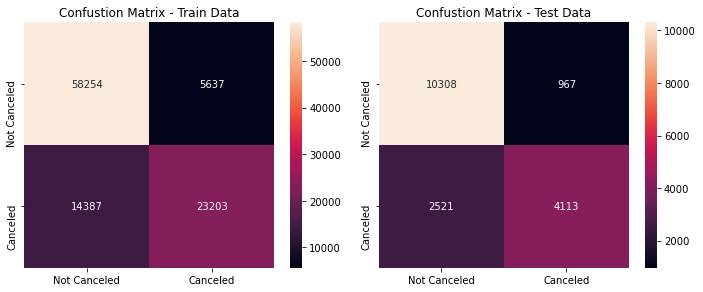

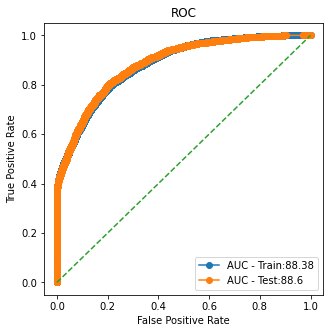

In [25]:
res_df = scores_train_test(lgr_model,X_train_sc,X_test_sc,y_train,y_test,lgr_train,lgr_test,'Base','LogisticRegression')

In [26]:
tempdf=res_df.copy()

In [27]:
clf = LinearDiscriminantAnalysis()
lda_model=clf.fit(X_train_sc, y_train)

lda_model_ytrain_predict = lda_model.predict(X_train_sc)
lda_model_ytest_predict = lda_model.predict(X_test_sc)

LDA
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
LDA_Base_Train,83.43,56.04,67.05,79.59,88.04
LDA_Base_Test,83.62,56.41,67.37,79.76,88.29


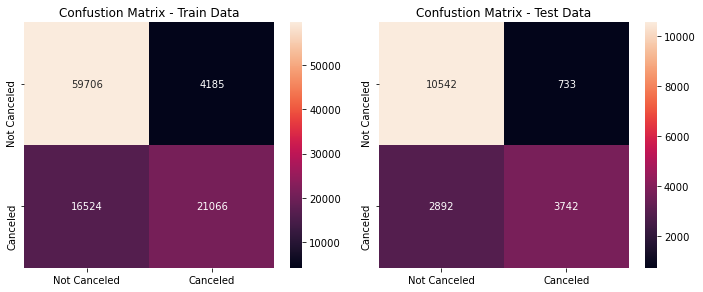

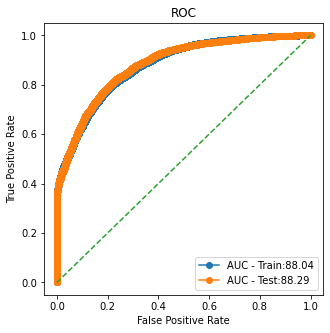

In [28]:
res_df=scores_train_test(clf,X_train_sc,X_test_sc,y_train,y_test,
                         lda_model_ytrain_predict,lda_model_ytest_predict,'Base','LDA')

In [29]:
tempdf = pd.concat([tempdf,res_df])

In [30]:
rfcl = RandomForestClassifier(random_state=0)

rfcl.fit(X_train_sc, y_train)
rf_train = rfcl.predict(X_train_sc)
rf_test = rfcl.predict(X_test_sc)

RandomForest
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
RandomForest_Base_Train,99.36,98.83,99.09,99.33,99.94
RandomForest_Base_Test,86.05,82.65,84.31,88.61,95.42


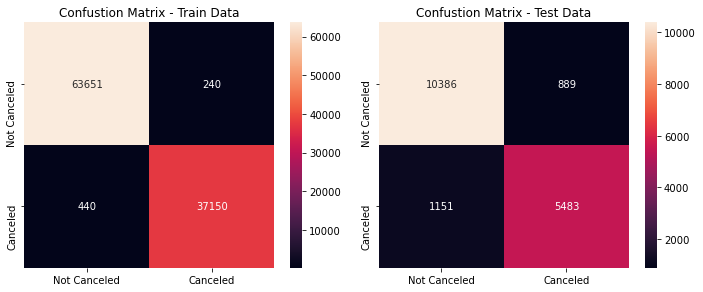

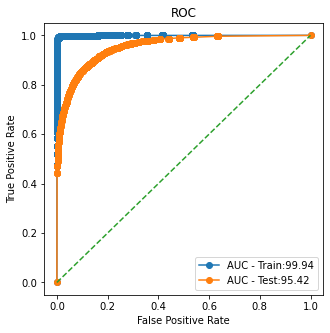

In [31]:
res_df = scores_train_test(rfcl,X_train_sc,X_test_sc,y_train,y_test,rf_train,rf_test,'Base','RandomForest')

In [32]:
#siva

In [33]:
tempdf = pd.concat([tempdf,res_df])

In [34]:
NB_model = GaussianNB()
NB_model.fit(X_train_sc, y_train)
NB_Model_y_predict_train = NB_model.predict(X_train_sc)
NB_Model_y_predict_test = NB_model.predict(X_test_sc)

GaussianNB
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
GaussianNB_Base_Train,97.55,38.16,54.86,76.74,80.80
GaussianNB_Base_Test,97.13,38.27,54.91,76.72,81.40


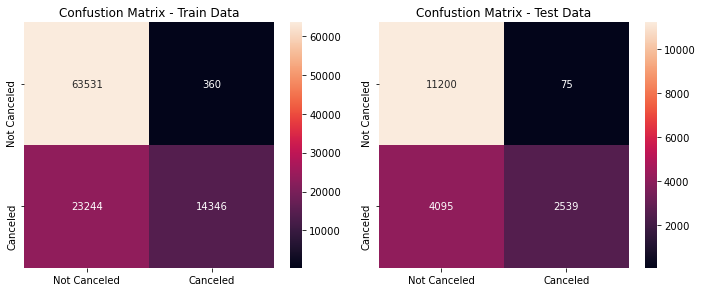

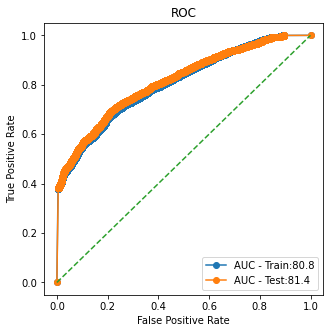

In [35]:
res_df=scores_train_test(NB_model,X_train_sc,X_test_sc,y_train,y_test,NB_Model_y_predict_train,NB_Model_y_predict_test,'Base','GaussianNB')

In [36]:
tempdf = pd.concat([tempdf,res_df])

In [37]:
xgbcl = XGBClassifier(use_label_encoder=True,objective='binary:hinge')
xgbcl.fit(X_train_sc,y_train)

xgtrainpredict = xgbcl.predict(X_train_sc)
xgtestpredict = xgbcl.predict(X_test_sc)

XGBoost
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
XGBoost_Base_Train,86.50,78.29,82.19,87.44,85.55
XGBoost_Base_Test,86.00,77.25,81.39,86.92,84.93


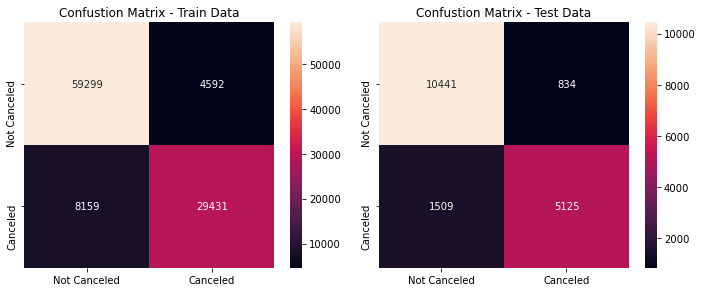

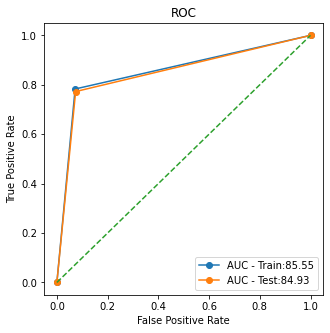

In [38]:
res_df=scores_train_test(xgbcl,X_train_sc,X_test_sc,y_train,y_test,xgtrainpredict,xgtestpredict,'Base','XGBoost')

In [39]:
tempdf = pd.concat([tempdf,res_df])

In [40]:
#Base model with K-Value as 5
KNN_Model = KNeighborsClassifier(n_neighbors=5)
KNN_Model.fit(X_train_sc,y_train)
KNN_train_p = KNN_Model.predict(X_train_sc)
KNN_test_p = KNN_Model.predict(X_test_sc)

K-NN
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
K-NN_Base_Train,87.54,83.99,85.73,89.64,96.64
K-NN_Base_Test,81.89,78.75,80.29,85.68,91.54


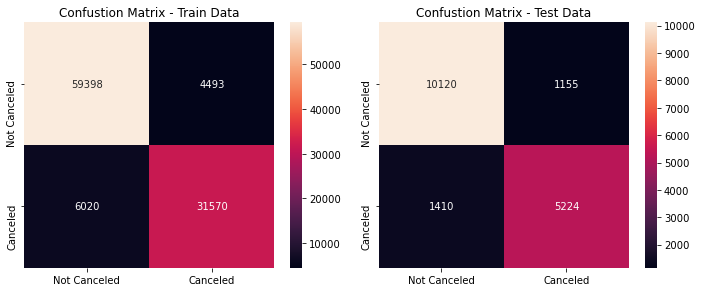

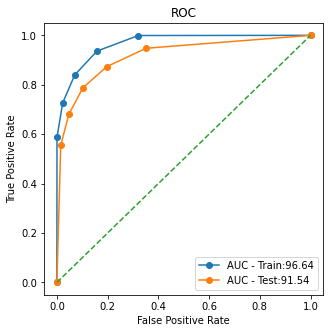

In [41]:
res_df=scores_train_test(KNN_Model,X_train_sc,X_test_sc,y_train,y_test,KNN_train_p,KNN_test_p,'Base','K-NN')

In [42]:
tempdf = pd.concat([tempdf,res_df])

ANN
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
ANN_Base_Train,83.87,78.78,81.24,86.53,94.11
ANN_Base_Test,82.39,77.52,79.89,85.54,93.22


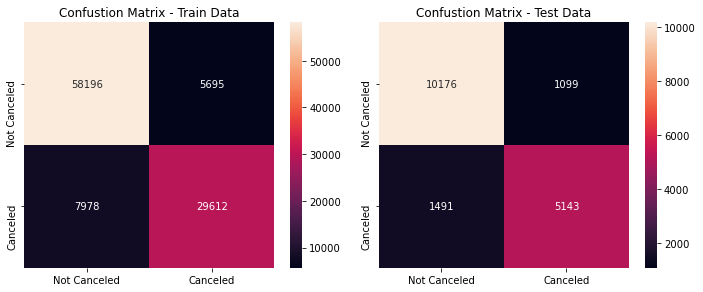

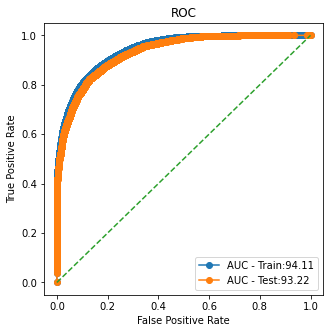

In [43]:
from sklearn.neural_network import MLPClassifier
NNModel = MLPClassifier(random_state=0)
NNModel.fit(X_train_sc,y_train)

NNTrainPredict = NNModel.predict(X_train_sc)
NNTestPredict = NNModel.predict(X_test_sc)
res_df=scores_train_test(NNModel,X_train_sc,X_test_sc,y_train,y_test,NNTrainPredict,NNTestPredict,'Base','ANN')
tempdf = pd.concat([tempdf,res_df])

In [44]:
def report_gen(tt,bagboost):
    tt = tt.reset_index().drop('index',axis=1)
    tt['Model']=tt['Scores'].str.split('_',n=1,expand=True)[0]
    tt['TT']=tt['Scores'].str.split('_',n=1,expand=True)[1].str.split('_',n=1,expand=True)[0]
    tt['BT']=tt['Scores'].str.split('_',n=1,expand=True)[1].str.split('_',n=1,expand=True)[1]
    tt.drop('Scores',axis=1,inplace=True)
    tt = tt[['Model','BT','TT','Precision','Recall','F-Score','Accuracy','AUC']]
    tt_report = tt[((tt['TT']!='Bagging') & (tt['TT']!='Boost'))]

    trg = tt_report.groupby(['Model','TT','BT'])['Precision','Recall','F-Score','Accuracy','AUC'].max().sort_values(by=['Model','TT','BT'],ascending=False)

    metdf = ((trg.T).reset_index()).rename(columns={'index': 'Model'})
    display_dataframe(metdf)

    if (bagboost == True):
        tt_bag = tt[(tt['TT']=='Bagging')]
        tt_boost = tt[(tt['TT']=='Boost')]
        trg_bag = tt_bag.groupby(['Model','TT','BT'])['Precision','Recall','F-Score','Accuracy','AUC'].max().sort_values(by=['Model','TT','BT'],ascending=False)
        trg_boost = tt_boost.groupby(['Model','TT','BT'])['Precision','Recall','F-Score','Accuracy','AUC'].max().sort_values(by=['Model','TT','BT'],ascending=False)
        metdf_bag = ((trg_bag.T).reset_index()).rename(columns={'index': 'Model'})
        metdf_boost = ((trg_boost.T).reset_index()).rename(columns={'index': 'Model'})
        display_dataframe(metdf_bag)
        display_dataframe(metdf_boost)

In [45]:
report_gen(tempdf,False)

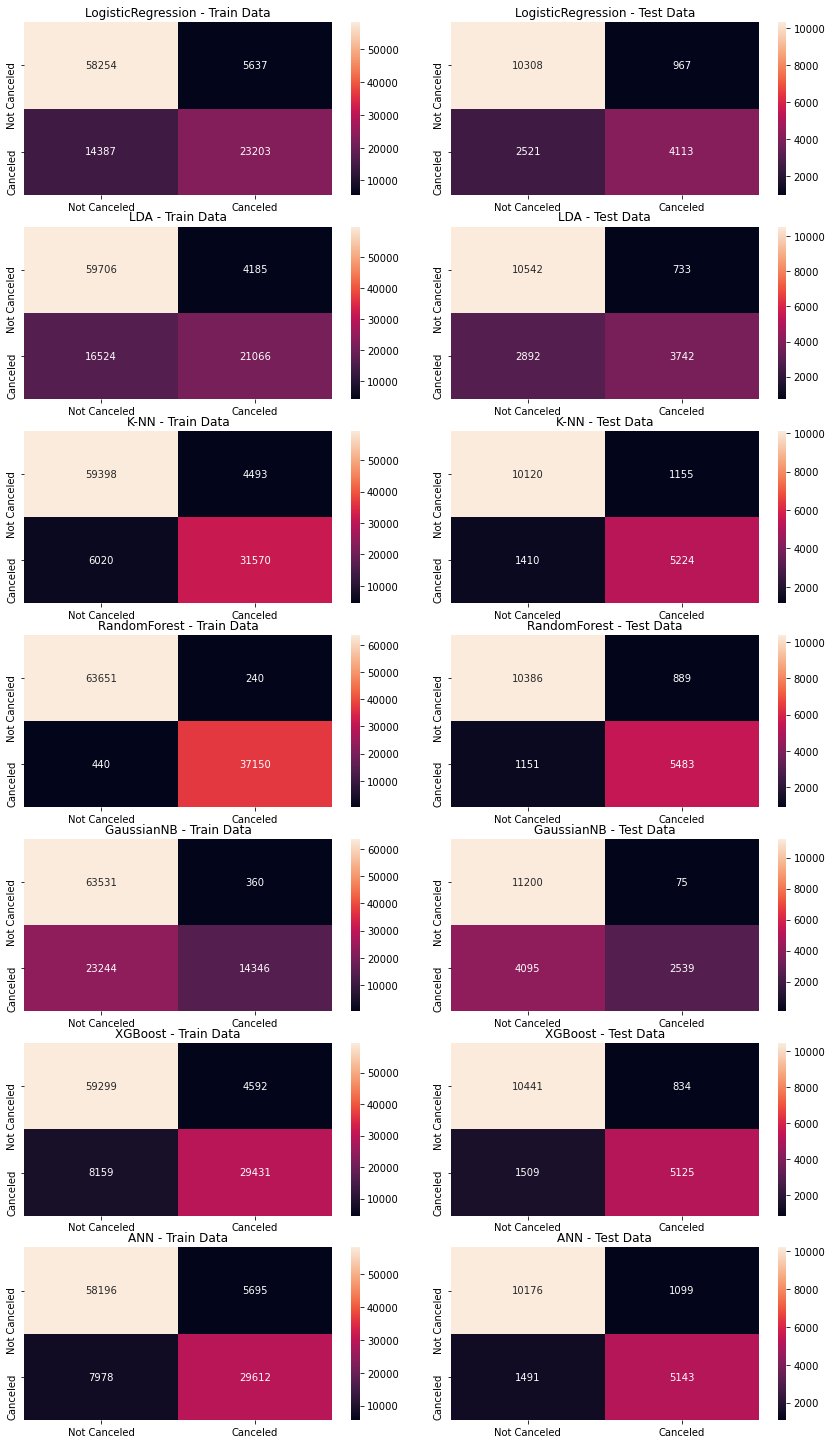

In [46]:
train_preds = [lgr_train,lda_model_ytrain_predict,KNN_train_p,rf_train,NB_Model_y_predict_train,xgtrainpredict,NNTrainPredict]

test_preds = [lgr_test,lda_model_ytest_predict,KNN_test_p,rf_test,NB_Model_y_predict_test,xgtestpredict,NNTestPredict]

mnames = ['LogisticRegression','LDA','K-NN','RandomForest','GaussianNB','XGBoost','ANN']

con_mat_r(y_train,train_preds,y_test,test_preds,2,12,20,mnames)

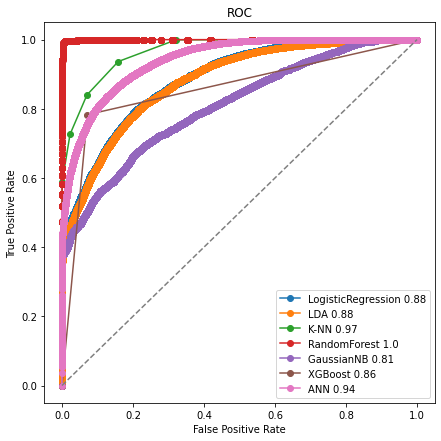

In [47]:
models=[lgr_model,lda_model,KNN_Model,rfcl,NB_model,xgbcl,NNModel]
plt.figure(figsize=(7,7))

c=0
for m in models:
    tprobs, tauc, tfpr, ttpr = roc_model(m,X_train_sc,y_train)
    plt.plot(tfpr,ttpr, marker='o', label=mnames[c] + ' ' + str(round(tauc,2)))
    
    c=c+1

plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

plt.show()

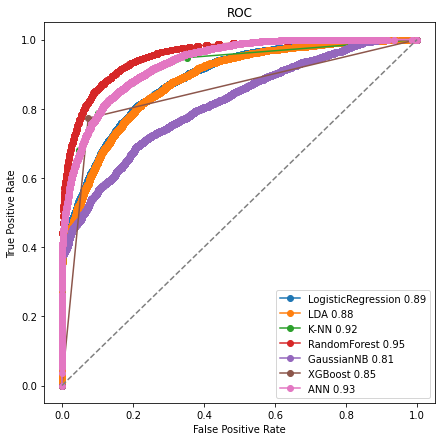

In [48]:
plt.figure(figsize=(7,7))
c=0
for m in models:
    tprobs, tauc, tfpr, ttpr = roc_model(m,X_test_sc,y_test)
    plt.plot(tfpr,ttpr, marker='o', label=mnames[c] + ' ' + str(round(tauc,2)))
    
    c=c+1

plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

plt.show()

Model Tuning - Logistic Regression

In [49]:
# #Logistic Regression with GridSearc CV
# def lgrun(x_train,train_labels,x_test,tol,max_iter,n_jobs,sol,C,penality,sco):
#     param_grid = {
#         'penalty': penality,
#         'C':C,
#         'max_iter':max_iter,
#         'solver':sol,
#         'n_jobs':n_jobs,
#         'tol':tol
#     },


#     clf = LogisticRegression(random_state=0)

#     grid_clf_acc = GridSearchCV(clf, param_grid = param_grid,scoring = sco,cv=3)
#     grid_clf_acc.fit(x_train, train_labels)
#     lgr_model=grid_clf_acc.best_estimator_
#     print(grid_clf_acc.best_params_)    
#     lgr_model
#     lgr_train=lgr_model.predict(x_train)
#     lgr_test=lgr_model.predict(x_test)

#     return(lgr_model,lgr_train,lgr_test)

In [50]:
# penalty=['none','11','l2',]
# solver=['newton-cg','liblinear']#,,'lbfgs','sag','liblinear','saga']
# tol=[0.01,0.001]
# C =[0.1,0.01]
# maxit = [2000]
# njobs = [8,9]

# lgr_model,lgr_train,lgr_test = lgrun(X_train_sc,y_train,X_test_sc,tol,maxit,njobs,solver,C,penalty,'accuracy')

In [51]:
# res_df = scores_train_test(lgr_model,X_train_sc,X_test_sc,y_train,y_test,lgr_train,lgr_test,'Tuned','LogisticRegression')

In [52]:
# tempdf = pd.concat([tempdf,res_df])

Model Tuning - LinearDiscriminantAnalysis

In [53]:
# #LDA with GridSearc CV
# def ldarun(x_train,train_labels,x_test,tol,sol,sco):
#     param_grid = {
#         'solver':sol,
#         'tol':tol,
#         'n_components':[1,2]
#     },
    
#     clf = LinearDiscriminantAnalysis()

#     grid_clf_acc = GridSearchCV(clf, param_grid = param_grid, cv=3,
#                       scoring=sco,n_jobs=1 ,verbose =0)
                                
#     grid_clf_acc.fit(x_train, train_labels)
#     lda_model=grid_clf_acc.best_estimator_
#     print(grid_clf_acc.best_params_)    
#     lda_train=lgr_model.predict(x_train)
#     lda_test=lgr_model.predict(x_test)
#     return(lda_model,lda_train,lda_test)

In [54]:
# solver=['svd','eigen']
# tol=[0.01,0.01,0.00001]

# lda_model,lda_model_ytrain_predict,lda_model_ytest_predict = ldarun(X_train_sc,y_train,X_test_sc,tol,solver,'accuracy')

In [55]:
# res_df=scores_train_test(clf,X_train_sc,X_test_sc,y_train,y_test,lda_model_ytrain_predict,lda_model_ytest_predict,'Tuned','LDA')

In [56]:
# tempdf = pd.concat([tempdf,res_df])

Model Tuning - Random Forest

In [57]:
def rfrun(x_train,train_labels,x_test,max_f,no_est,max_dep,min_sam,min_spl):
    param_grid = {
        'criterion': ['gini'],
        'max_depth': max_dep, #,7,9],
        'max_features':max_f, #,32],
        'min_samples_leaf': min_sam,#15,20],
        'min_samples_split': min_spl,#75,60],
        'n_estimators': no_est
    }

    rfcl = RandomForestClassifier(random_state=0)

    grid_search = GridSearchCV(estimator = rfcl, param_grid = param_grid, cv = 3,scoring='accuracy')
    grid_search.fit(x_train, train_labels)
    print(grid_search.best_params_)
    
    rfcl = grid_search.best_estimator_
    rfcl

    rf_train = rfcl.predict(x_train)
    rf_test = rfcl.predict(x_test)
    return(rfcl,rf_train,rf_test)   

In [60]:
from datetime import datetime
now = datetime.now()

b_current_time = datetime.now().strftime("%H:%M:%S")
print("Current Time =", b_current_time)

Current Time = 11:04:03


In [61]:
rfcl,rfcl_y_predict_train,rfcl_y_predict_test = rfrun(X_train,y_train,X_test,[15,16],[75,85],[35,40],[1],[5])
#rfcl = RandomForestClassifier(random_state=0,max_features=16,max_depth=35,n_estimators=75,min_samples_leaf=1,min_samples_split=5)
rfcl.fit(X_train_sc,y_train)

rfcl_y_predict_train = rfcl.predict(X_train_sc)
rfcl_y_predict_test = rfcl.predict(X_test_sc)

{'criterion': 'gini', 'max_depth': 35, 'max_features': 16, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 75}


In [62]:
a_now = datetime.now()

a_current_time = a_now - now
print("Time Taken =", a_current_time)

Time Taken = 0:04:53.346837


RandomForest
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
RandomForest_Tuned_Train,97.41,95.79,96.59,97.50,99.75
RandomForest_Tuned_Test,86.71,83.48,85.06,89.14,95.79


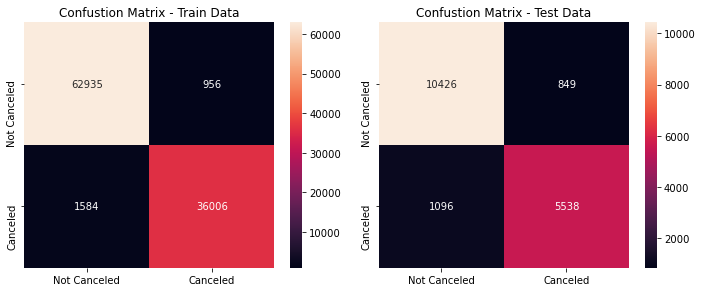

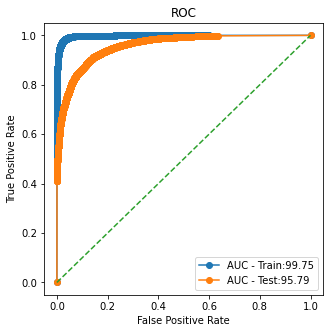

In [63]:
res_df = scores_train_test(rfcl,X_train_sc,X_test_sc,y_train,y_test,rfcl_y_predict_train,rfcl_y_predict_test,'Tuned','RandomForest')

In [64]:
tempdf = pd.concat([tempdf,res_df])

Model Tuning - XGBoost

In [72]:
now = datetime.now()

b_current_time = datetime.now().strftime("%H:%M:%S")
print("Current Time =", b_current_time)

Current Time = 12:29:15


In [73]:
xgbcl = XGBClassifier()
param_grid = {
    'n_estimators': [150],
    'colsample_bytree': [0.7],
    'max_depth': [15],
    'reg_alpha': [1.1],
    'reg_lambda': [1.1],
    'subsample': [0.7],
    'objective':['binary:hinge']
}
grid = GridSearchCV(xgbcl, 
                    param_grid = param_grid, 
                    scoring = "accuracy", 
                    cv = 3)


grid.fit(X_train_sc,y_train)


grid.best_estimator_
# Dictionary of best parameters

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=1,
              objective='binary:hinge', random_state=0, reg_alpha=1.1,
              reg_lambda=1.1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
a_now = datetime.now()

a_current_time = a_now - now
print("Time Taken =", a_current_time)

Time Taken = 0:01:33.548014


In [75]:
xgbcl = grid.best_estimator_
xgtrainpredict = xgbcl.predict(X_train_sc)
xgtestpredict = xgbcl.predict(X_test_sc)

XGBoost
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
XGBoost_Tuned_Train,95.80,95.51,95.65,96.79,96.52
XGBoost_Tuned_Test,84.19,83.58,83.89,88.11,87.18


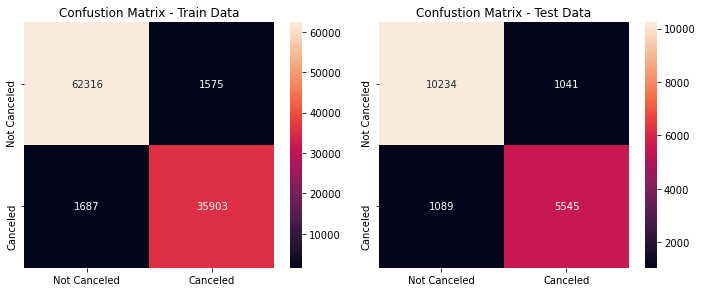

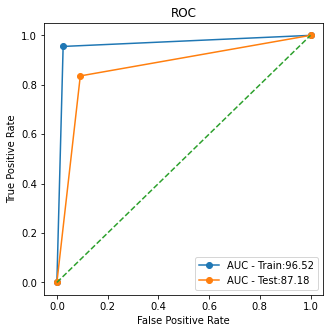

In [76]:
res_df=scores_train_test(xgbcl,X_train_sc,X_test_sc,y_train,y_test,xgtrainpredict,xgtestpredict,'Tuned','XGBoost')

In [77]:
tempdf = pd.concat([tempdf,res_df])

Model Tuning - Neural Networks

In [78]:
from datetime import datetime
now = datetime.now()

b_current_time = datetime.now().strftime("%H:%M:%S")
print("Current Time =", b_current_time)

Current Time = 12:30:50


In [79]:
param_grid = {
    'hidden_layer_sizes': [200,350],
    'max_iter': [500,750],
    'solver': ['sgd','adam'],
    'tol': [0.01,0.001],
}

nncl = MLPClassifier(random_state=9)

NNModel = GridSearchCV(estimator = nncl, param_grid = param_grid, cv = 3)

NNModel.fit(X_train_sc, y_train)

NNModel.best_estimator_

MLPClassifier(hidden_layer_sizes=350, max_iter=500, random_state=9, tol=0.001)

In [80]:
a_now = datetime.now()

a_current_time = a_now - now
print("Time Taken =", a_current_time)

Time Taken = 0:29:51.896884


In [81]:
NNTrainPredict = NNModel.predict(X_train_sc)
NNTestPredict = NNModel.predict(X_test_sc)

ANN
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
ANN_Tuned_Train,81.24,80.73,80.98,85.96,93.85
ANN_Tuned_Test,80.73,79.94,80.33,85.50,93.24


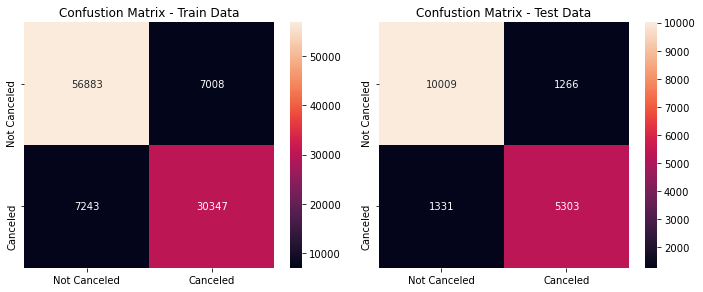

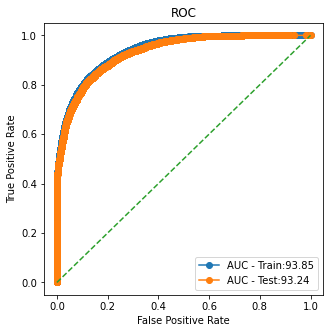

In [82]:
res_df=scores_train_test(NNModel,X_train_sc,X_test_sc,y_train,y_test,NNTrainPredict,NNTestPredict,'Tuned','ANN')

In [83]:
tempdf = pd.concat([tempdf,res_df])

Model Tuning - K-NN

In [84]:
now = datetime.now()

b_current_time = datetime.now().strftime("%H:%M:%S")
print("Current Time =", b_current_time)

Current Time = 13:00:44


In [85]:
acc=[]
for i in range(3,15,3):
    KNN_Model = KNeighborsClassifier(n_neighbors=i,metric='euclidean')
    KNN_Model.fit(X_train_sc,y_train)

    y_test_p = KNN_Model.predict(X_test_sc)
    score_knn = KNN_Model.score(X_test_sc,y_test)
    print(f'Accuracy Score for K={i} : ',score_knn)
    acc.append(score_knn)
    
MCE = [1 - x for x in acc]
MCE    

Accuracy Score for K=3 :  0.8533139762130773
Accuracy Score for K=6 :  0.8597911664526215
Accuracy Score for K=9 :  0.8586185716678765
Accuracy Score for K=12 :  0.8577810039644871


[0.14668602378692275,
 0.14020883354737845,
 0.14138142833212353,
 0.1422189960355129]

In [86]:
a_now = datetime.now()

a_current_time = a_now - now
print("Time Taken =", a_current_time)

Time Taken = 0:04:41.155392


Text(0, 0.5, 'Misclassification Error')

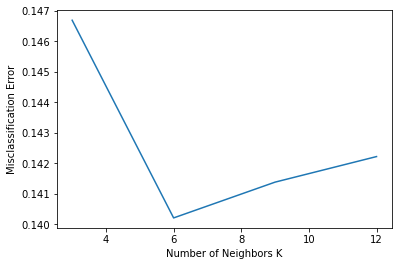

In [87]:
import matplotlib.pyplot as plt
plt.plot(range(3,15,3),MCE)

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')

In [88]:
now = datetime.now()

b_current_time = datetime.now().strftime("%H:%M:%S")
print("Current Time =", b_current_time)

Current Time = 13:05:25


In [89]:
k=6
KNN_Model = KNeighborsClassifier(n_neighbors=k,metric='euclidean')
KNN_Model.fit(X_train_sc,y_train)
KNN_train_p = KNN_Model.predict(X_train_sc)
KNN_test_p = KNN_Model.predict(X_test_sc)
print(f'Accuracy Score for K={k} : ',KNN_Model.score(X_test_sc,y_test))

Accuracy Score for K=6 :  0.8597911664526215


In [90]:
a_now = datetime.now()

a_current_time = a_now - now
print("Time Taken =", a_current_time)

Time Taken = 0:04:52.101608


K-NN
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
K-NN_Tuned_Train,90.47,78.30,83.94,88.91,96.26
K-NN_Tuned_Test,85.61,74.71,79.79,85.98,91.91


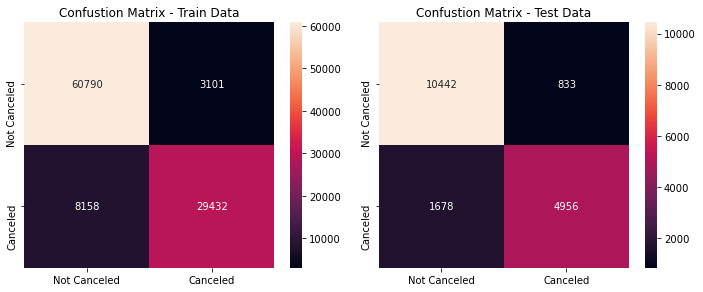

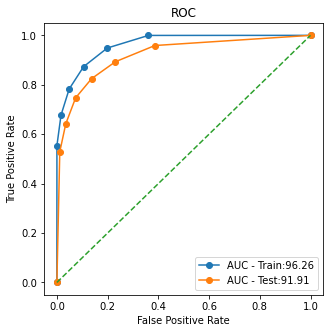

In [91]:
#KNN Model Scores
res_df=scores_train_test(KNN_Model,X_train_sc,X_test_sc,y_train,y_test,KNN_train_p,KNN_test_p,'Tuned','K-NN')

In [92]:
tempdf = pd.concat([tempdf,res_df])

Model Tuning - GaussianNB

In [93]:
# params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
# NB_model = GridSearchCV(estimator=NB_model, 
#                  param_grid=params_NB, 
#                  cv=5,   # use any cross validation technique 
#                  verbose=1, 
#                  scoring='accuracy') 
# NB_model.fit(X_train_sc, y_train)

# NB_model.best_params_

In [94]:
# NB_Model_y_predict_train = NB_model.predict(X_train_sc)
# NB_Model_y_predict_test = NB_model.predict(X_test_sc)

In [95]:
# res_df=scores_train_test(NB_model,X_train_sc,X_test_sc,y_train,y_test,NB_Model_y_predict_train,NB_Model_y_predict_test,'Tuned','GaussianNB')

In [96]:
# tempdf = pd.concat([tempdf,res_df])

In [97]:
now = datetime.now()

b_current_time = datetime.now().strftime("%H:%M:%S")
print("Current Time =", b_current_time)

Current Time = 13:14:26


Bagging Classifer

In [98]:
from sklearn.ensemble import BaggingClassifier
bgcl = BaggingClassifier(base_estimator=rfcl, n_estimators=50,random_state=0)

bgcl = bgcl.fit(X_train_sc, y_train)

bgcl_y_predict_train = bgcl.predict(X_train_sc)
bgcl_y_predict_test = bgcl.predict(X_test_sc)

In [99]:
a_now = datetime.now()

a_current_time = a_now - now
print("Time Taken =", a_current_time)

Time Taken = 0:08:39.617042


BaggingClassifier
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
BaggingClassifier_Bagging_Train,94.73,91.18,92.92,94.85,99.18
BaggingClassifier_Bagging_Test,86.68,82.77,84.68,88.91,95.85


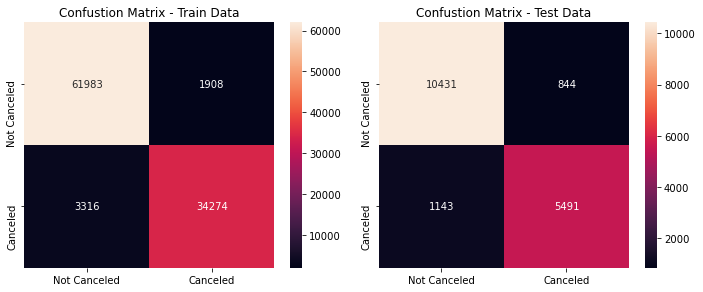

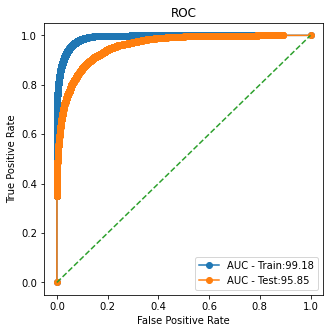

In [100]:
res_df = scores_train_test(bgcl,X_train_sc,X_test_sc,y_train,y_test,bgcl_y_predict_train,bgcl_y_predict_test,'Bagging','BaggingClassifier')

In [101]:
tempdf = pd.concat([tempdf,res_df])

AdaBoosting

In [102]:
now = datetime.now()

b_current_time = datetime.now().strftime("%H:%M:%S")
print("Current Time =", b_current_time)

Current Time = 13:24:47


In [103]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(n_estimators=10, random_state=0)

abcl = abcl.fit(X_train_sc, y_train)
abcl_y_predict_train = abcl.predict(X_train_sc)
abcl_y_predict_test = bgcl.predict(X_test_sc)

In [104]:
a_now = datetime.now()

a_current_time = a_now - now
print("Time Taken =", a_current_time)

Time Taken = 0:00:14.485452


AdaBoostClassifier
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
AdaBoostClassifier_Boost_Train,79.98,67.36,73.13,81.66,88.00
AdaBoostClassifier_Boost_Test,86.68,82.77,84.68,88.91,88.25


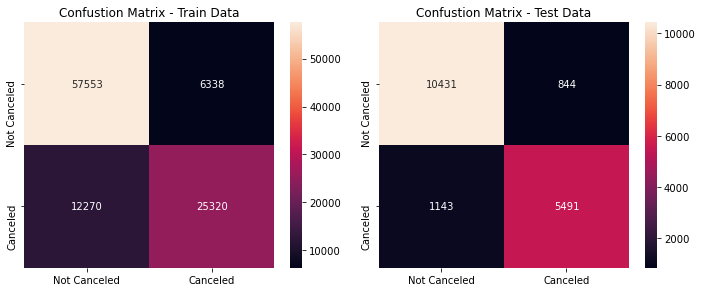

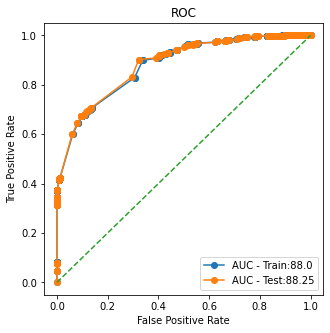

In [105]:
res_df = scores_train_test(abcl,X_train_sc,X_test_sc,y_train,y_test,abcl_y_predict_train,abcl_y_predict_test,'Boost','AdaBoostClassifier')

In [106]:
tempdf = pd.concat([tempdf,res_df])

GradientBoosting

In [107]:
now = datetime.now()

b_current_time = datetime.now().strftime("%H:%M:%S")
print("Current Time =", b_current_time)

Current Time = 13:25:02


In [108]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(random_state=0)
gbcl = gbcl.fit(X_train_sc, y_train)

gbcl_y_predict_train = gbcl.predict(X_train_sc)
gbcl_y_predict_test = gbcl.predict(X_test_sc)

In [109]:
a_now = datetime.now()

a_current_time = a_now - now
print("Time Taken =", a_current_time)

Time Taken = 0:00:13.442875


GradientBoostingClassifier
********************************



Scores,Precision,Recall,F-Score,Accuracy,AUC
GradientBoostingClassifier_Boost_Train,83.95,73.47,78.36,84.97,92.63
GradientBoostingClassifier_Boost_Test,84.45,73.44,78.56,85.15,92.86


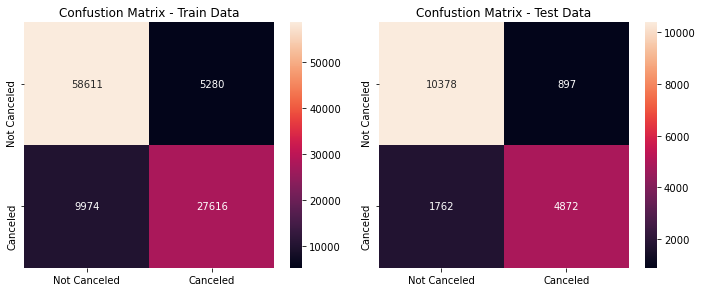

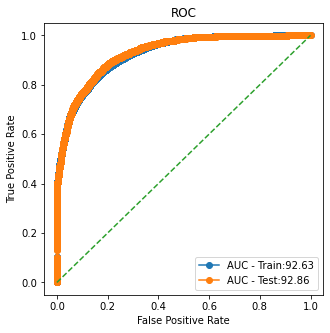

In [110]:
res_df = scores_train_test(gbcl,X_train_sc,X_test_sc,y_train,y_test,gbcl_y_predict_train,gbcl_y_predict_test,'Boost','GradientBoostingClassifier')

In [111]:
tempdf = pd.concat([tempdf,res_df])

In [112]:
report_gen(tempdf,True)

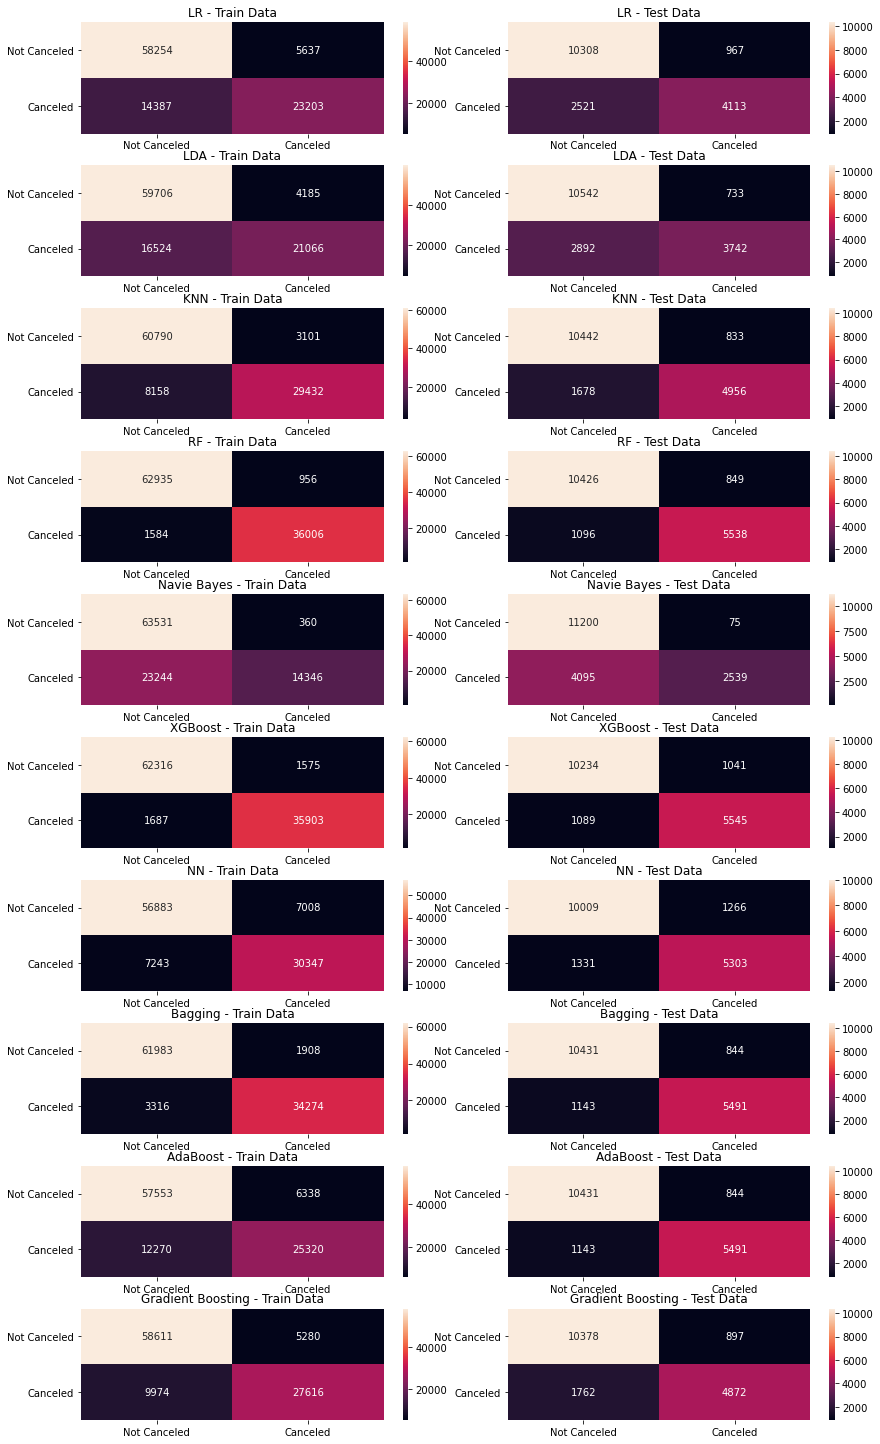

In [113]:
train_preds = [lgr_train,lda_model_ytrain_predict,KNN_train_p,rfcl_y_predict_train,NB_Model_y_predict_train,xgtrainpredict,NNTrainPredict,bgcl_y_predict_train,abcl_y_predict_train,gbcl_y_predict_train]

test_preds = [lgr_test,lda_model_ytest_predict,KNN_test_p,rfcl_y_predict_test,NB_Model_y_predict_test,xgtestpredict,NNTestPredict,bgcl_y_predict_test,abcl_y_predict_test,gbcl_y_predict_test]

mnames = ['LR','LDA','KNN','RF','Navie Bayes','XGBoost','NN','Bagging','AdaBoost','Gradient Boosting']

con_mat_r(y_train,train_preds,y_test,test_preds,2,12,20,mnames)

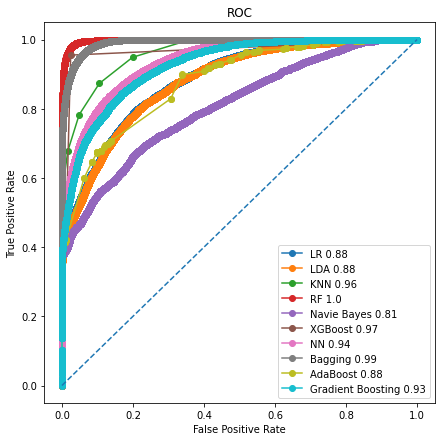

In [114]:
models=[lgr_model,lda_model,KNN_Model,rfcl,NB_model,xgbcl,NNModel,bgcl,abcl,gbcl]
plt.figure(figsize=(7,7))

c=0
for m in models:
    tprobs, tauc, tfpr, ttpr = roc_model(m,X_train_sc,y_train)
    plt.plot(tfpr,ttpr, marker='o', label=mnames[c] + ' ' + str(round(tauc,2)))
    
    c=c+1

plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

plt.show()

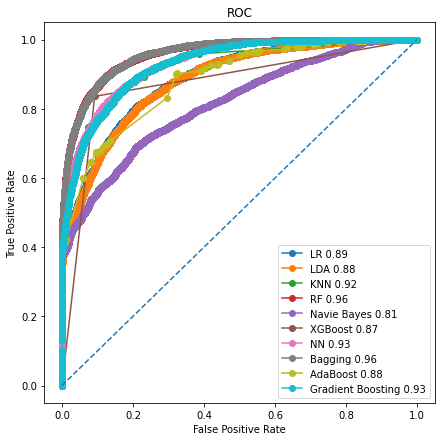

In [115]:
plt.figure(figsize=(7,7))
c=0
for m in models:
    tprobs, tauc, tfpr, ttpr = roc_model(m,X_test_sc,y_test)
    plt.plot(tfpr,ttpr, marker='o', label=mnames[c] + ' ' + str(round(tauc,2)))
    
    c=c+1

plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

plt.show()